In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')

sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    # "/storage/vbutoi/scratch/ESE/training/07_09_24_ACDC_SoftDiceLoss",
    # "/storage/vbutoi/scratch/ESE/training/07_09_24_ACDC_PixelCELoss_wSVLS" # SVLS Models Seed 40
    # "/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_TempScaling_HardGT", # Calibrated from above.
    # "/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_IBTS_HardGT", # Calibrated from above.
    # "/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_LTS_HardGT", # Calibrated from above.
    # "/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT", # Calibrated from above.
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [3]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
dice_score
ece_loss
edge_ece_loss
data
iters_per_epoch
label_threshold
num_examples
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
loss_func
batch_reduction
from_logits
model
image_channels
init_mode
ksize
num_classes
optim
lr
weight_decay
checkpoint
epochs
eval_freq
pretrained_dir
pretrained_select_metric
path


In [4]:
# For num_examples, where it is NaN make it 20.
if 'num_examples' in df.keys():
    df['num_examples'] = df['num_examples'].fillna(20)
else:
    df['num_examples'] = 20

In [5]:
# Get the path where num_examples is 20.
df[df['num_examples'] == 20]['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT/20240723_120815-S870-d6717ff15b449240d5822898f01d753c'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT/20240723_120803-N0S9-ba6f6d3431a4d3ccc2f3127413289538'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT/20240723_120811-FN0I-104e1ecb552b5d372a14780506e700e2'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT/20240723_120759-AFHU-09c99120d1a6d1230535b2253677f790'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT/20240723_120807-RUS0-9e102662358d0ed8d63b49631ddb1631'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/07_23_24_ACDC_CalibrationSuite_Popcorn_HardGT/20240723_120755-LI3D-a74beff8e835fdc968d70a2564db00d1'),
       PosixPath('/storage/vbutoi/

In [6]:
# Sort the df by the seed.
df = df.sort_values(by='seed')
# Change the type of the seed column to a string
df['seed'] = df['seed'].astype(str)

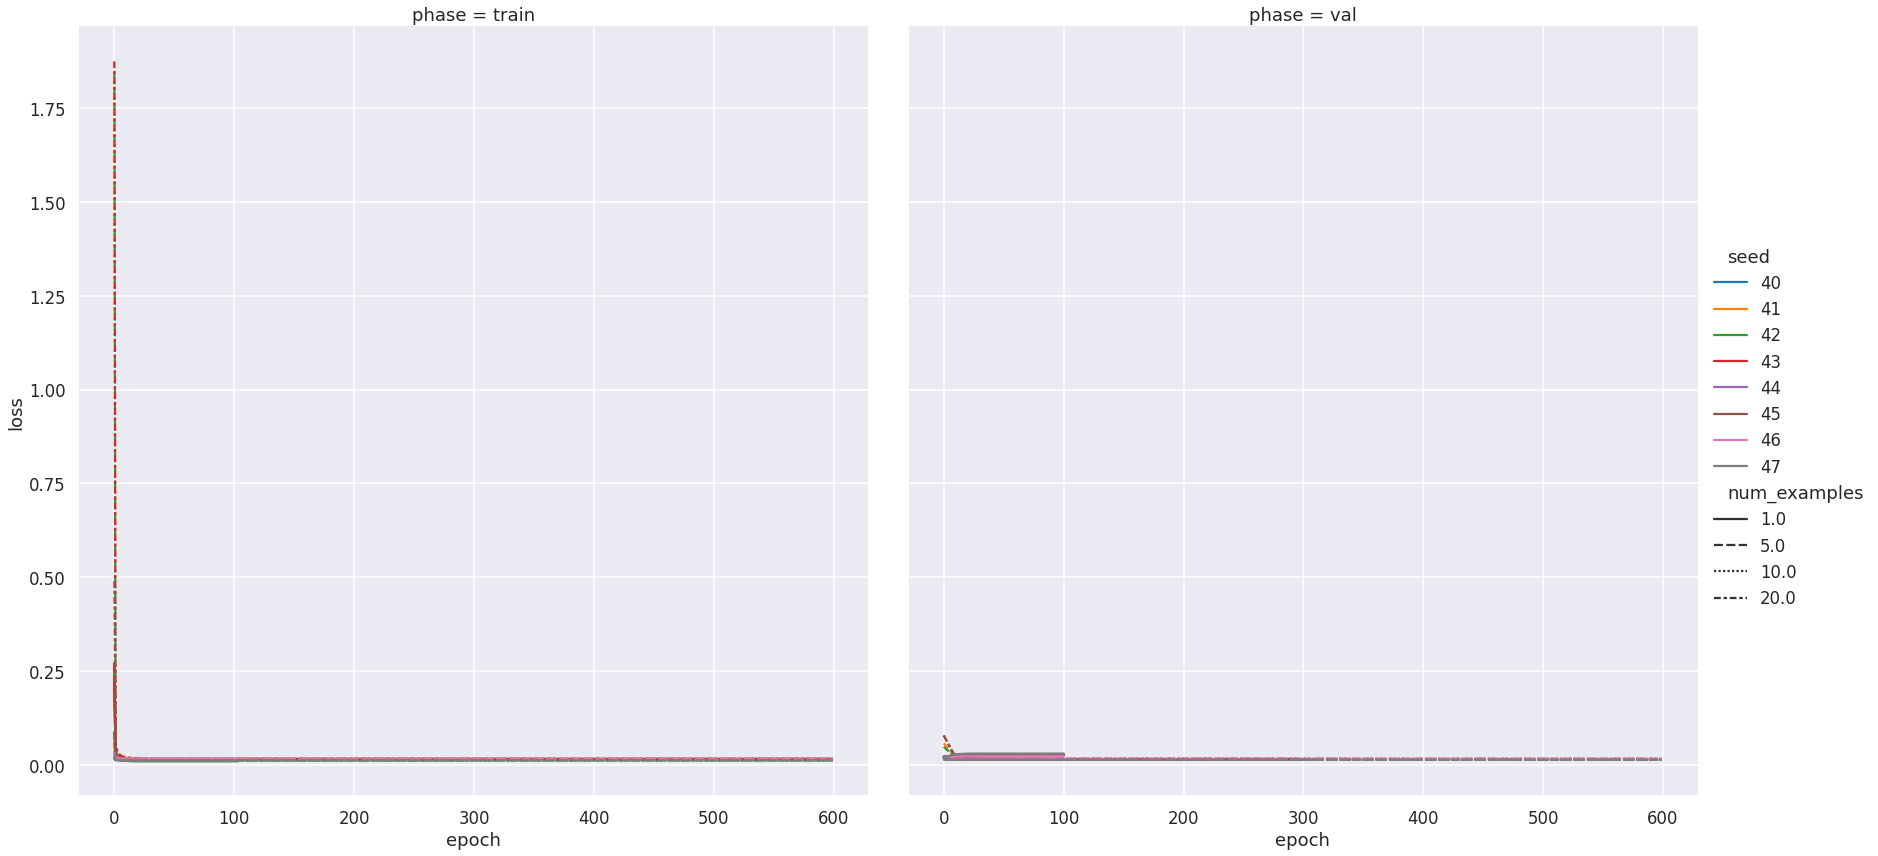

In [7]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='seed',
    style='num_examples',
    col='phase',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [8]:
# We want to make a custom palette that will differentiate across methods. Specifically, if the method
# is Popcorn_Scaling then we want it to be from the 'Blues' family otherwise we want it to be from the 'YlOrBr' family.
# custom_palette = {df['opt_method'].unique()[i]: sns.color_palette('Blues', n_colors=len(df['opt_method'].unique()))[i] if 'Popcorn_Scaling' in df['opt_method'].unique()[i] else sns.color_palette('YlOrBr', n_colors=len(df['opt_method'].unique()))[i] for i in range(len(df['opt_method'].unique()))}

In [9]:
# g = sns.relplot(
#     data=df,
#     x='epoch',
#     y='dice_score',
#     hue='seed',
#     col='phase',
#     kind='line',
#     height=12,
#     # palette=custom_palette
# )

# # Set column spacing
# g.fig.subplots_adjust(wspace=0.05)
# # g.set(ylim=(0.0, 0.25))

In [16]:
num_examples_df = df[df['num_examples'] == 1]

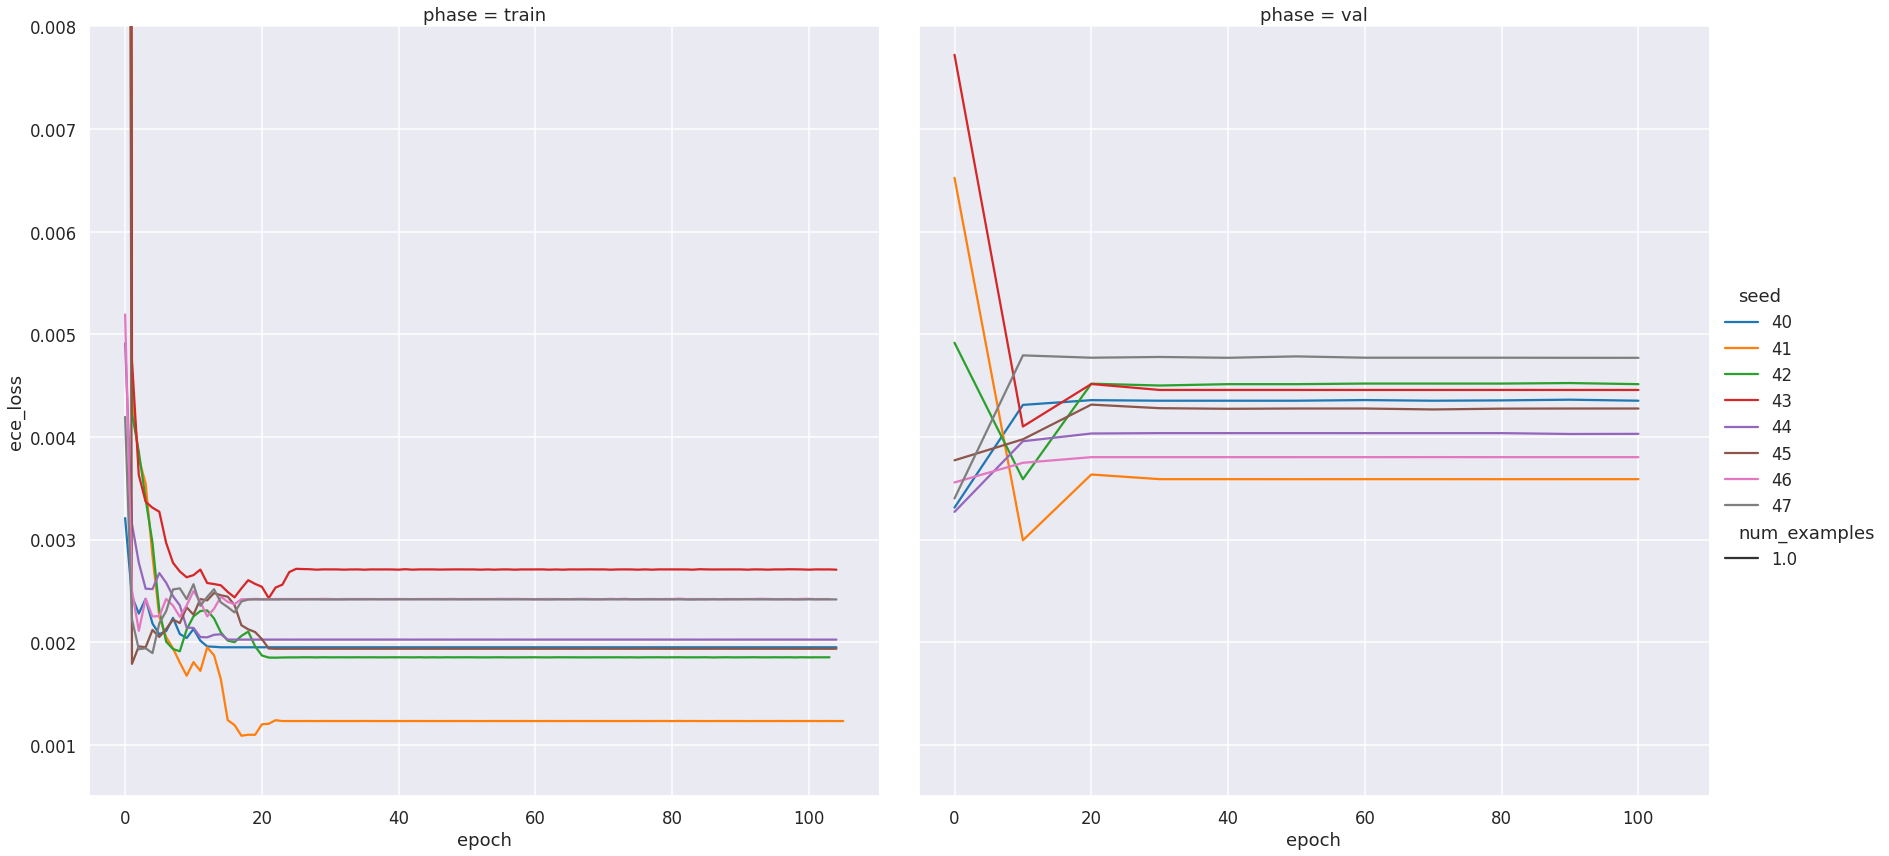

In [17]:
g = sns.relplot(
    data=num_examples_df,
    x='epoch',
    y='ece_loss',
    hue='seed',
    style='num_examples',
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
# Set the y axis to be between 0.008 and 0.001
g.set(ylim=(0.0005, 0.008))
g.fig.subplots_adjust(wspace=0.05)